In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
from create_training_instance_dictionary_with_covariates import *
from feature_extraction import *
from sample_from_full_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
# Create training_instance_dict and extract features
##############################
# Load data and create a training_instance dictionary with covariates and M proteins only in the period of interest. 
DATA_CHOICE = "FISH_only"
M_number_of_measurements = 6
treat_id = 16
list_of_included_treatments = [treat_id] #[1,2,3,7,10,13,15,16]
patient_dictionary, training_instance_dict = create_training_instance_dictionary_with_covariates(minimum_number_of_measurements=M_number_of_measurements, global_treatment_id_list=list_of_included_treatments, verbose=False)
# Keep only patients that are in EHR data: 
COMMPASS_current_name_list = [elem[0] for elem in training_instance_dict.values()]
df_EHR = pd.read_excel('./COMMPASS_data/220615_commpass_clinical_genomic_annotated_EHR.xlsx')
EHR_name_list = [elem.replace("_1_BM" ,"", 1) for elem in df_EHR.loc[:,"sample"]]
NEW_TRAIN_ID = 0
new_patient_dictionary = {}
new_training_instance_dict = {}
for training_instance_id, patient in patient_dictionary.items(): # Dummy dictionary has training_instance_id as key
    this_name = COMMPASS_current_name_list[training_instance_id]
    if this_name in EHR_name_list: 
        new_patient_dictionary[NEW_TRAIN_ID] = patient_dictionary[training_instance_id] # equal to: "= patient"
        new_training_instance_dict[NEW_TRAIN_ID] = training_instance_dict[training_instance_id]
        NEW_TRAIN_ID = NEW_TRAIN_ID + 1
patient_dictionary = new_patient_dictionary
training_instance_dict = new_training_instance_dict

#for name, patient in patient_dictionary.items():
#    plot_true_mprotein_with_observations_and_treatments_and_estimate(Parameters(0.1, 0.1, 0.001, -0.001, 0, 0.1), patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(name), savename="./plots/Bayes_simulated_data/COMMPASS/"+str(name))

def standardize_Y_arrays(patient_dictionary):
    # standardize_input_from_dictionary
    y_pre_padding = np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()])
    #y_pre_padding = max(y_pre_padding,0)
    times_pre_padding = np.array([patient.measurement_times for _, patient in patient_dictionary.items()])
    times_pre_padding = [t_list-t_list[0] for t_list in times_pre_padding]# Account for nonzero time 0
    len_y_each_patient = np.array([len(elem) for elem in times_pre_padding])
    max_len_y = max(len_y_each_patient)
    y = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    times = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    for i in range(len(patient_dictionary)):
        for t in range(len_y_each_patient[i]):
            y[i][t] = y_pre_padding[i][t]
            times[i][t] = times_pre_padding[i][t]

    # Scale up Y to get it on a scale further away from zero
    y = 100*np.array([elem[0:M_number_of_measurements] for elem in y])
    times = np.array([elem[0:M_number_of_measurements] for elem in times])

    # y and times are cropped: Update the patient dictionary 
    cropped_dict = {}
    for training_instance_id in range(0, len(patient_dictionary)):
        cropped_dict[training_instance_id] = patient_dictionary[training_instance_id]
        cropped_dict[training_instance_id].measurement_times = times[training_instance_id]
        cropped_dict[training_instance_id].Mprotein_values = y[training_instance_id]
    return cropped_dict

# X and patient_dictionary are passed on to the sampling
X = feature_extraction(training_instance_dict, DATA_CHOICE=DATA_CHOICE)
patient_dictionary = standardize_Y_arrays(patient_dictionary)
# Check that dimensions are correct
assert X.shape[0] == len(patient_dictionary)
N_cases, P = X.shape
print("N_cases:", N_cases)

Done finding 40 training instances with at least 6 M protein measurements.
30 cases in training_instance_dict
Adding clinical covariates and treatment as covariate
Number of clinical covariates including drug indicators: 14
Adding clinical covariates by EHR
How many from EHR not in current COMMPASS name list (due to inclusion criteria not being satisfied): 722
How many from current COMMPASS not in EHR name list: 0
How many overlapping: 30
Standardizing some features...
How many from FISH not in current COMMPASS name list (due to inclusion criteria not being satisfied): 1045
How many from current COMMPASS not in FISH name list: 0
How many overlapping (FISH/prev COMPASS): 30
Removing the homebrewed ones...
Any nan values in df_EHR? True
Any nan values in df_clinical_covariates? False
Any nan values in df_X_covariates? False
Missing data filled with naive means not per group
Total number of covariates in df_X: 164
   SeqWGS_Cp_10p14  SeqWGS_Cp_10q23  SeqWGS_Cp_11p15  SeqWGS_Cp_11q23  \
0 

RunningCOMMPASS_treat_id_16_M_6_P_164_N_cases_30_psi_prior_normal_N_samples_3000_N_tuning_3000_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_True
Max(Y): 620.0
Max(t): 1164.0


Sampling: [Y_obs, alpha, c2_pi_r, c2_rho_r, c2_rho_s, lam_pi_r, lam_rho_r, lam_rho_s, omega, psi, sigma_obs, tau_pi_r, tau_rho_r, tau_rho_s, theta_pi_r_offset, theta_rho_r_offset, theta_rho_s_offset, z_pi_r, z_rho_r, z_rho_s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, tau_rho_s, tau_rho_r, tau_pi_r, lam_rho_s, lam_rho_r, lam_pi_r, c2_rho_s, c2_rho_r, c2_pi_r, z_rho_s, z_rho_r, z_pi_r, omega, theta_rho_s_offset, theta_rho_r_offset, theta_pi_r_offset, psi]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 5524 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Done sampling


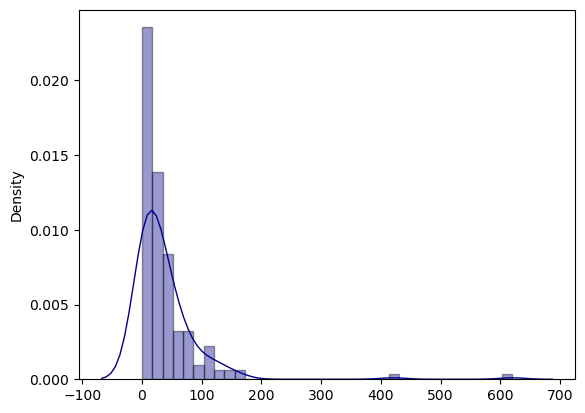

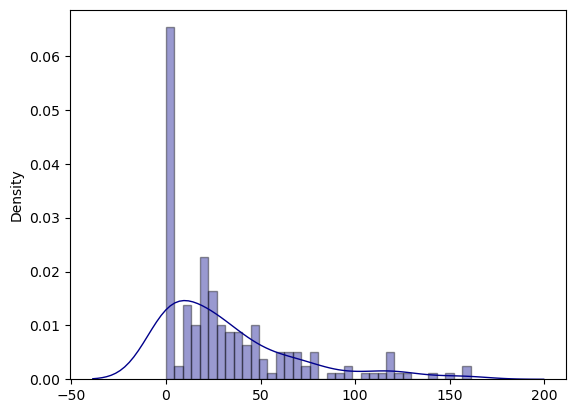

In [3]:
# Sample from full model
psi_prior="normal"
N_samples = 10000
N_tuning = 10000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = True
name = "COMMPASS_treat_id_"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running"+name)
idata = sample_from_full_model(X, patient_dictionary, name, N_samples=N_samples, N_tuning=N_tuning, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)
# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [4]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
Seems like chain 0 has not converged in alpha dimension 0 : z_score is -3.1346580502977126
Seems like chain 0 has not converged in alpha dimension 1 : z_score is -3.0115089002192166
Seems like chain 1 has not converged in alpha dimension 1 : z_score is 3.8331083847644027
Seems like chain 2 has not converged in alpha dimension 1 : z_score is -2.089844038757211
Seems like chain 3 has not converged in alpha dimension 0 : z_score is -4.322176907194424
Seems like chain 3 has not converged in alpha dimension 2 : z_score is 5.8145201803887065
Seems like chain 0 has not converged in beta_rho_s dimension 2 : z_score is -1.9708184977474554
Seems like chain 0 has not converged in beta_rho_s dimension 5 : z_score is -2.7246435352016714
Seems like chain 0 has not converged in beta_rho_s dimension 7 : z_score is 5.183892642339822
Seems like chain 0 has not converged in beta_rho_s dimension 8 : z_score is 3.827335318362699
Seems like chain 0 has not converged in beta_rho_s dime

0

In [5]:
# Get posterior mode estimates for visualization
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print(median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print(estimated_parameters_dict[0].to_array_with_sigma())


10.119894778950737
[ 8.67945425e+01  4.95209281e-02  6.01350407e-03 -1.04819943e-01
  0.00000000e+00  1.01198948e+01]


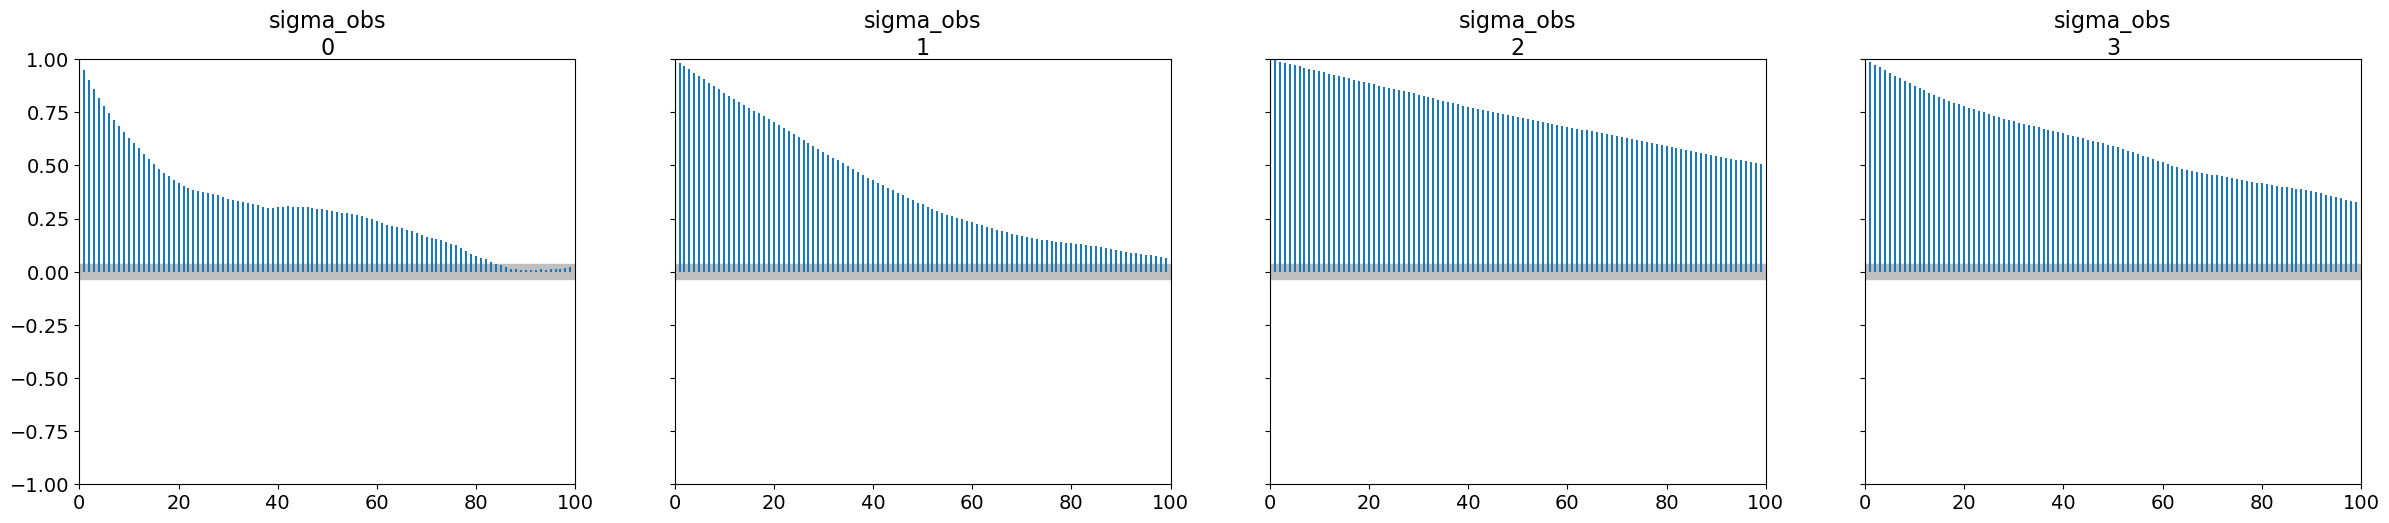

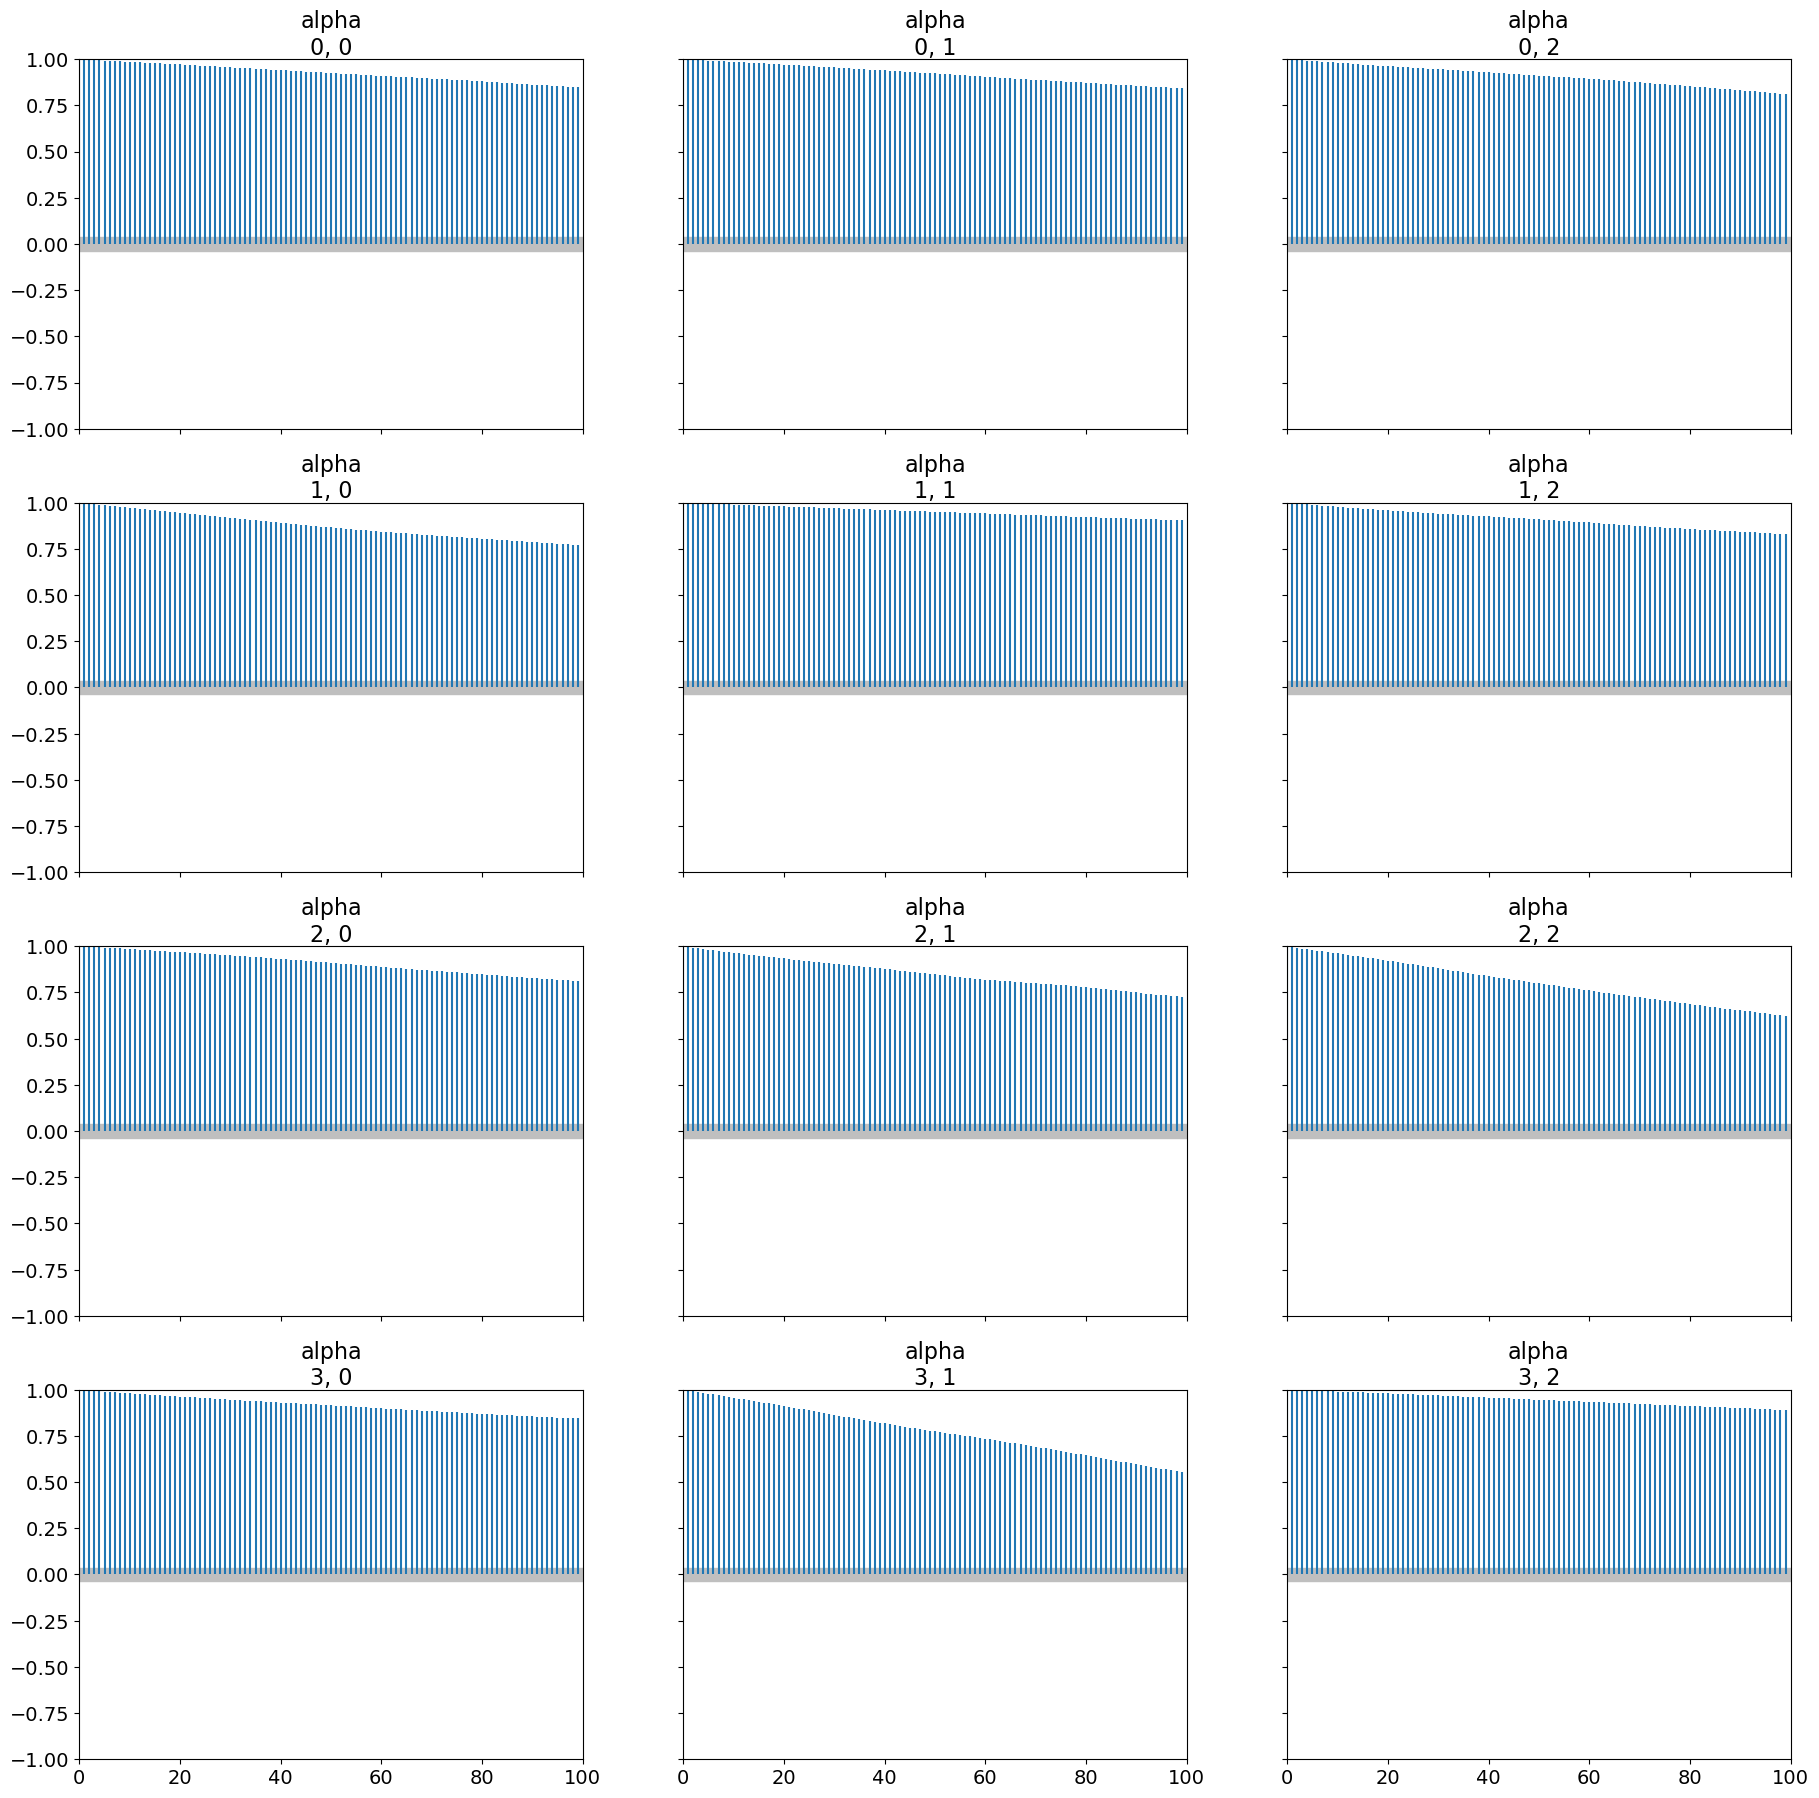

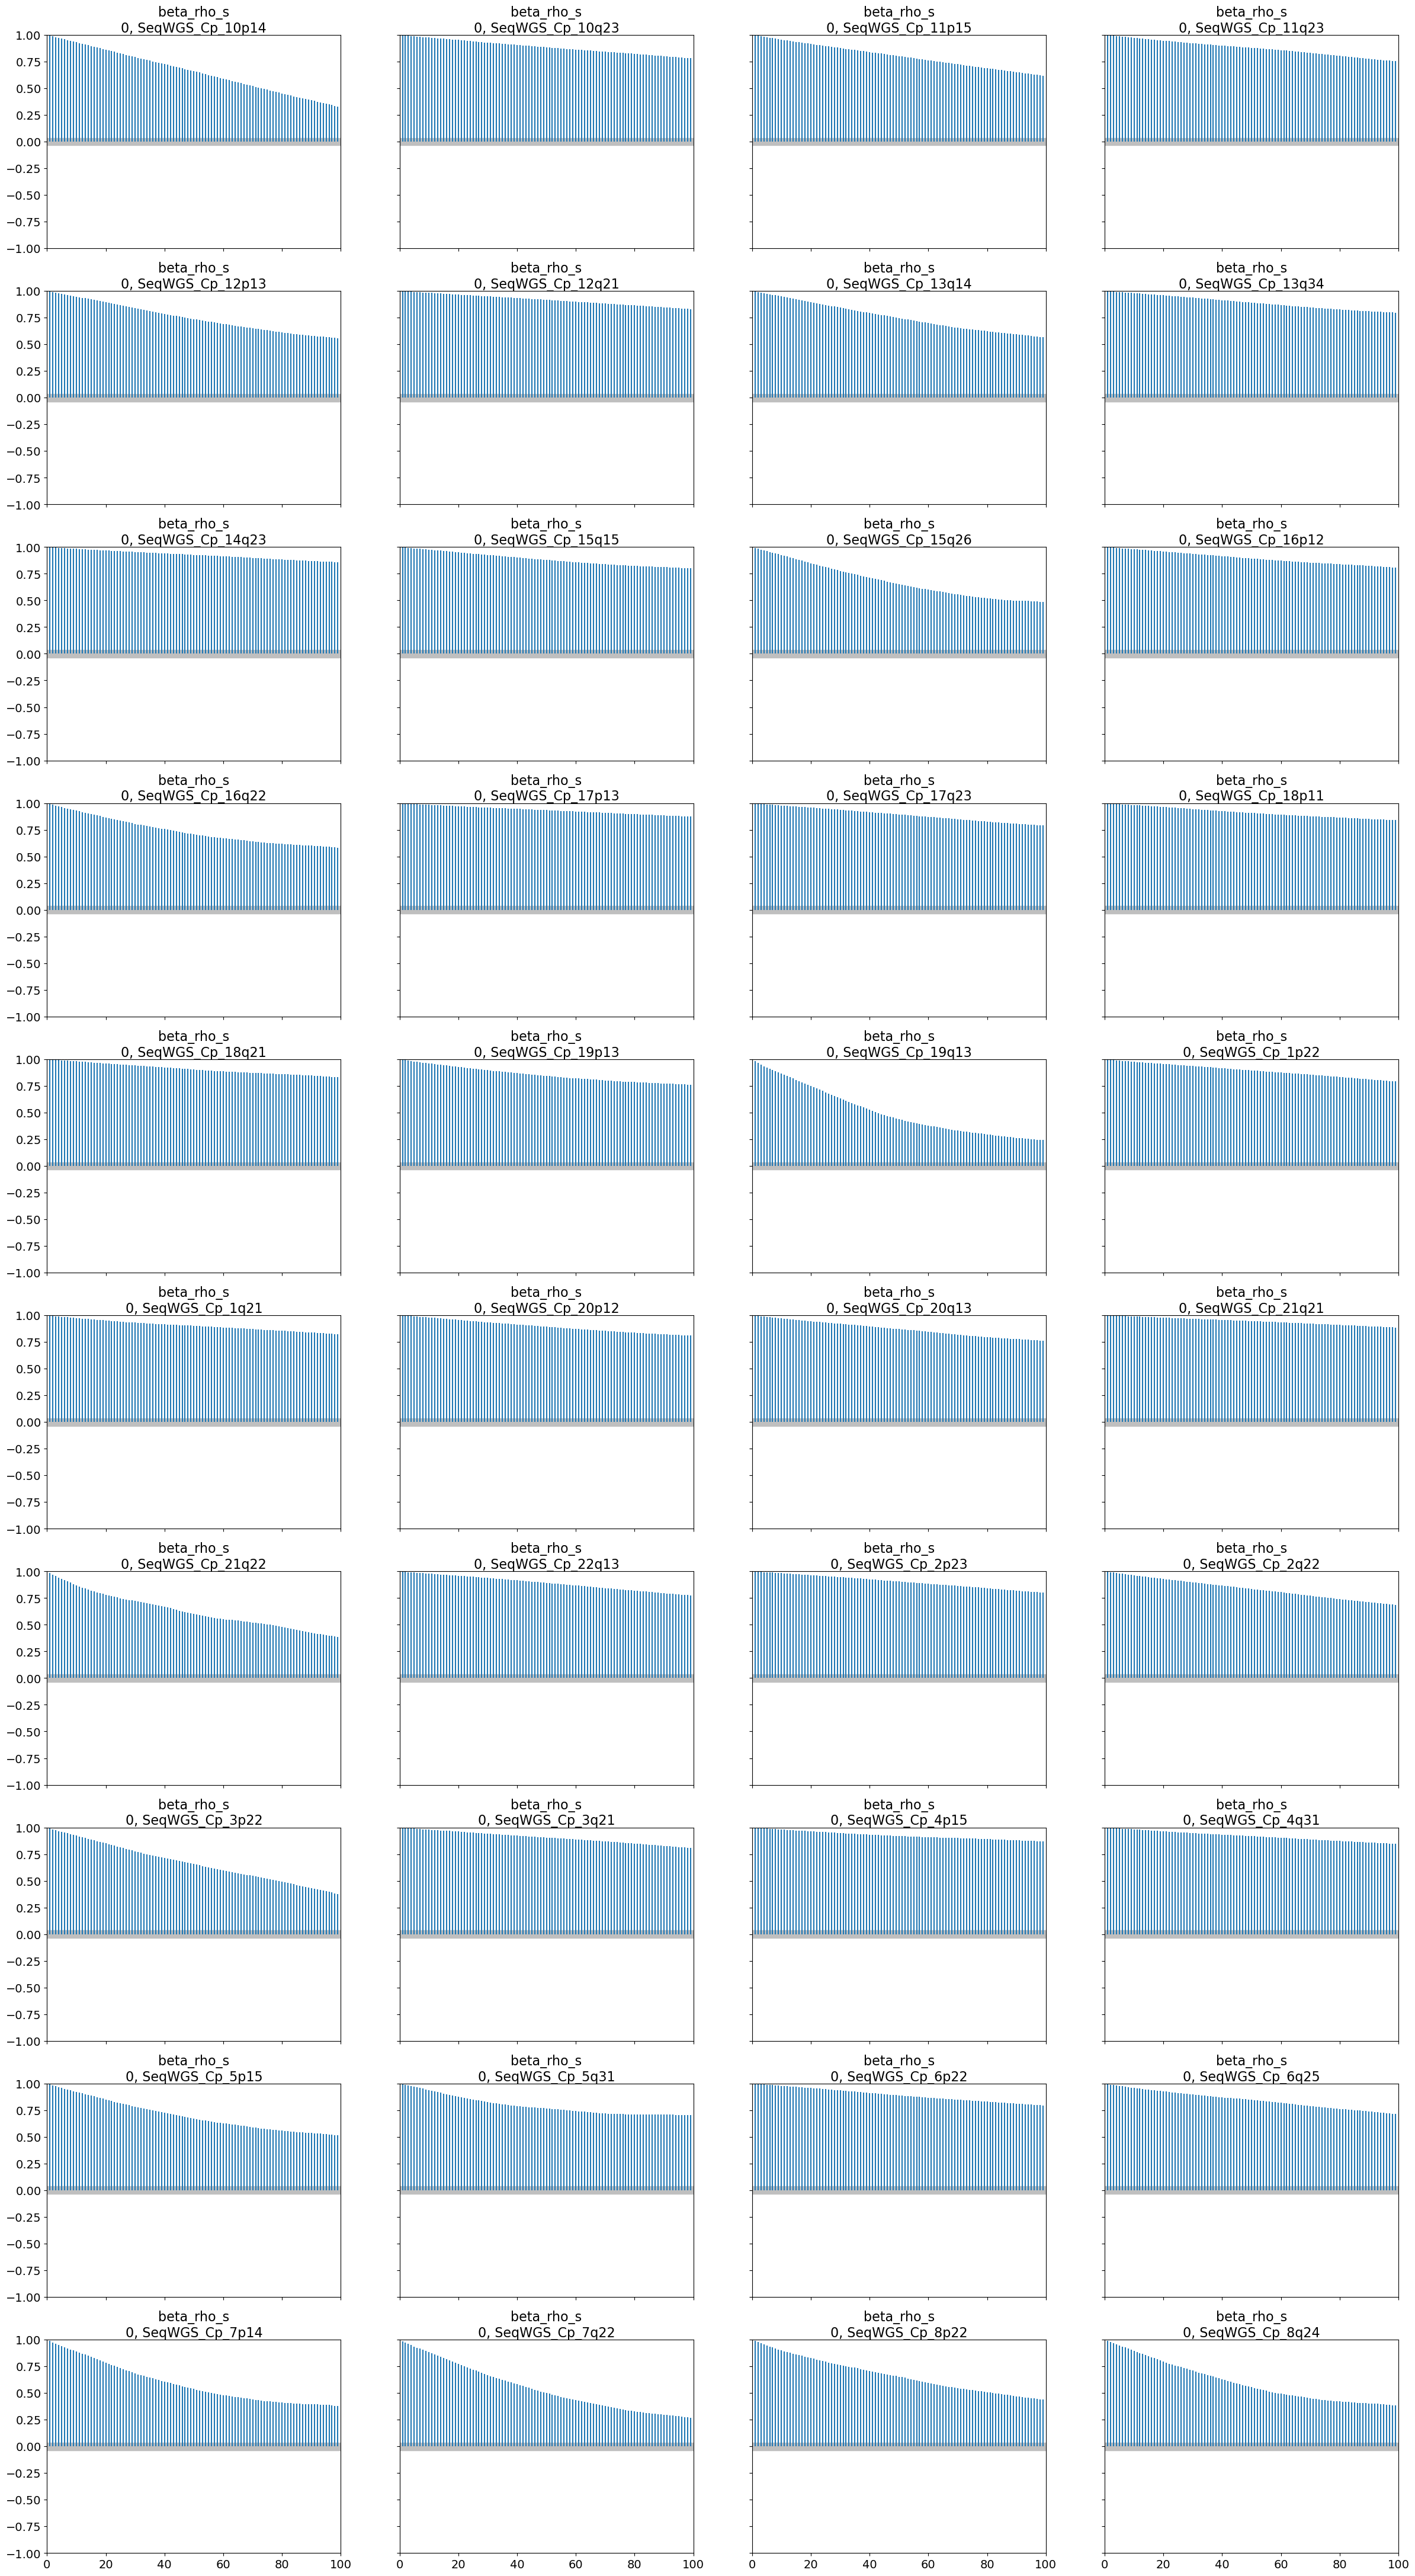

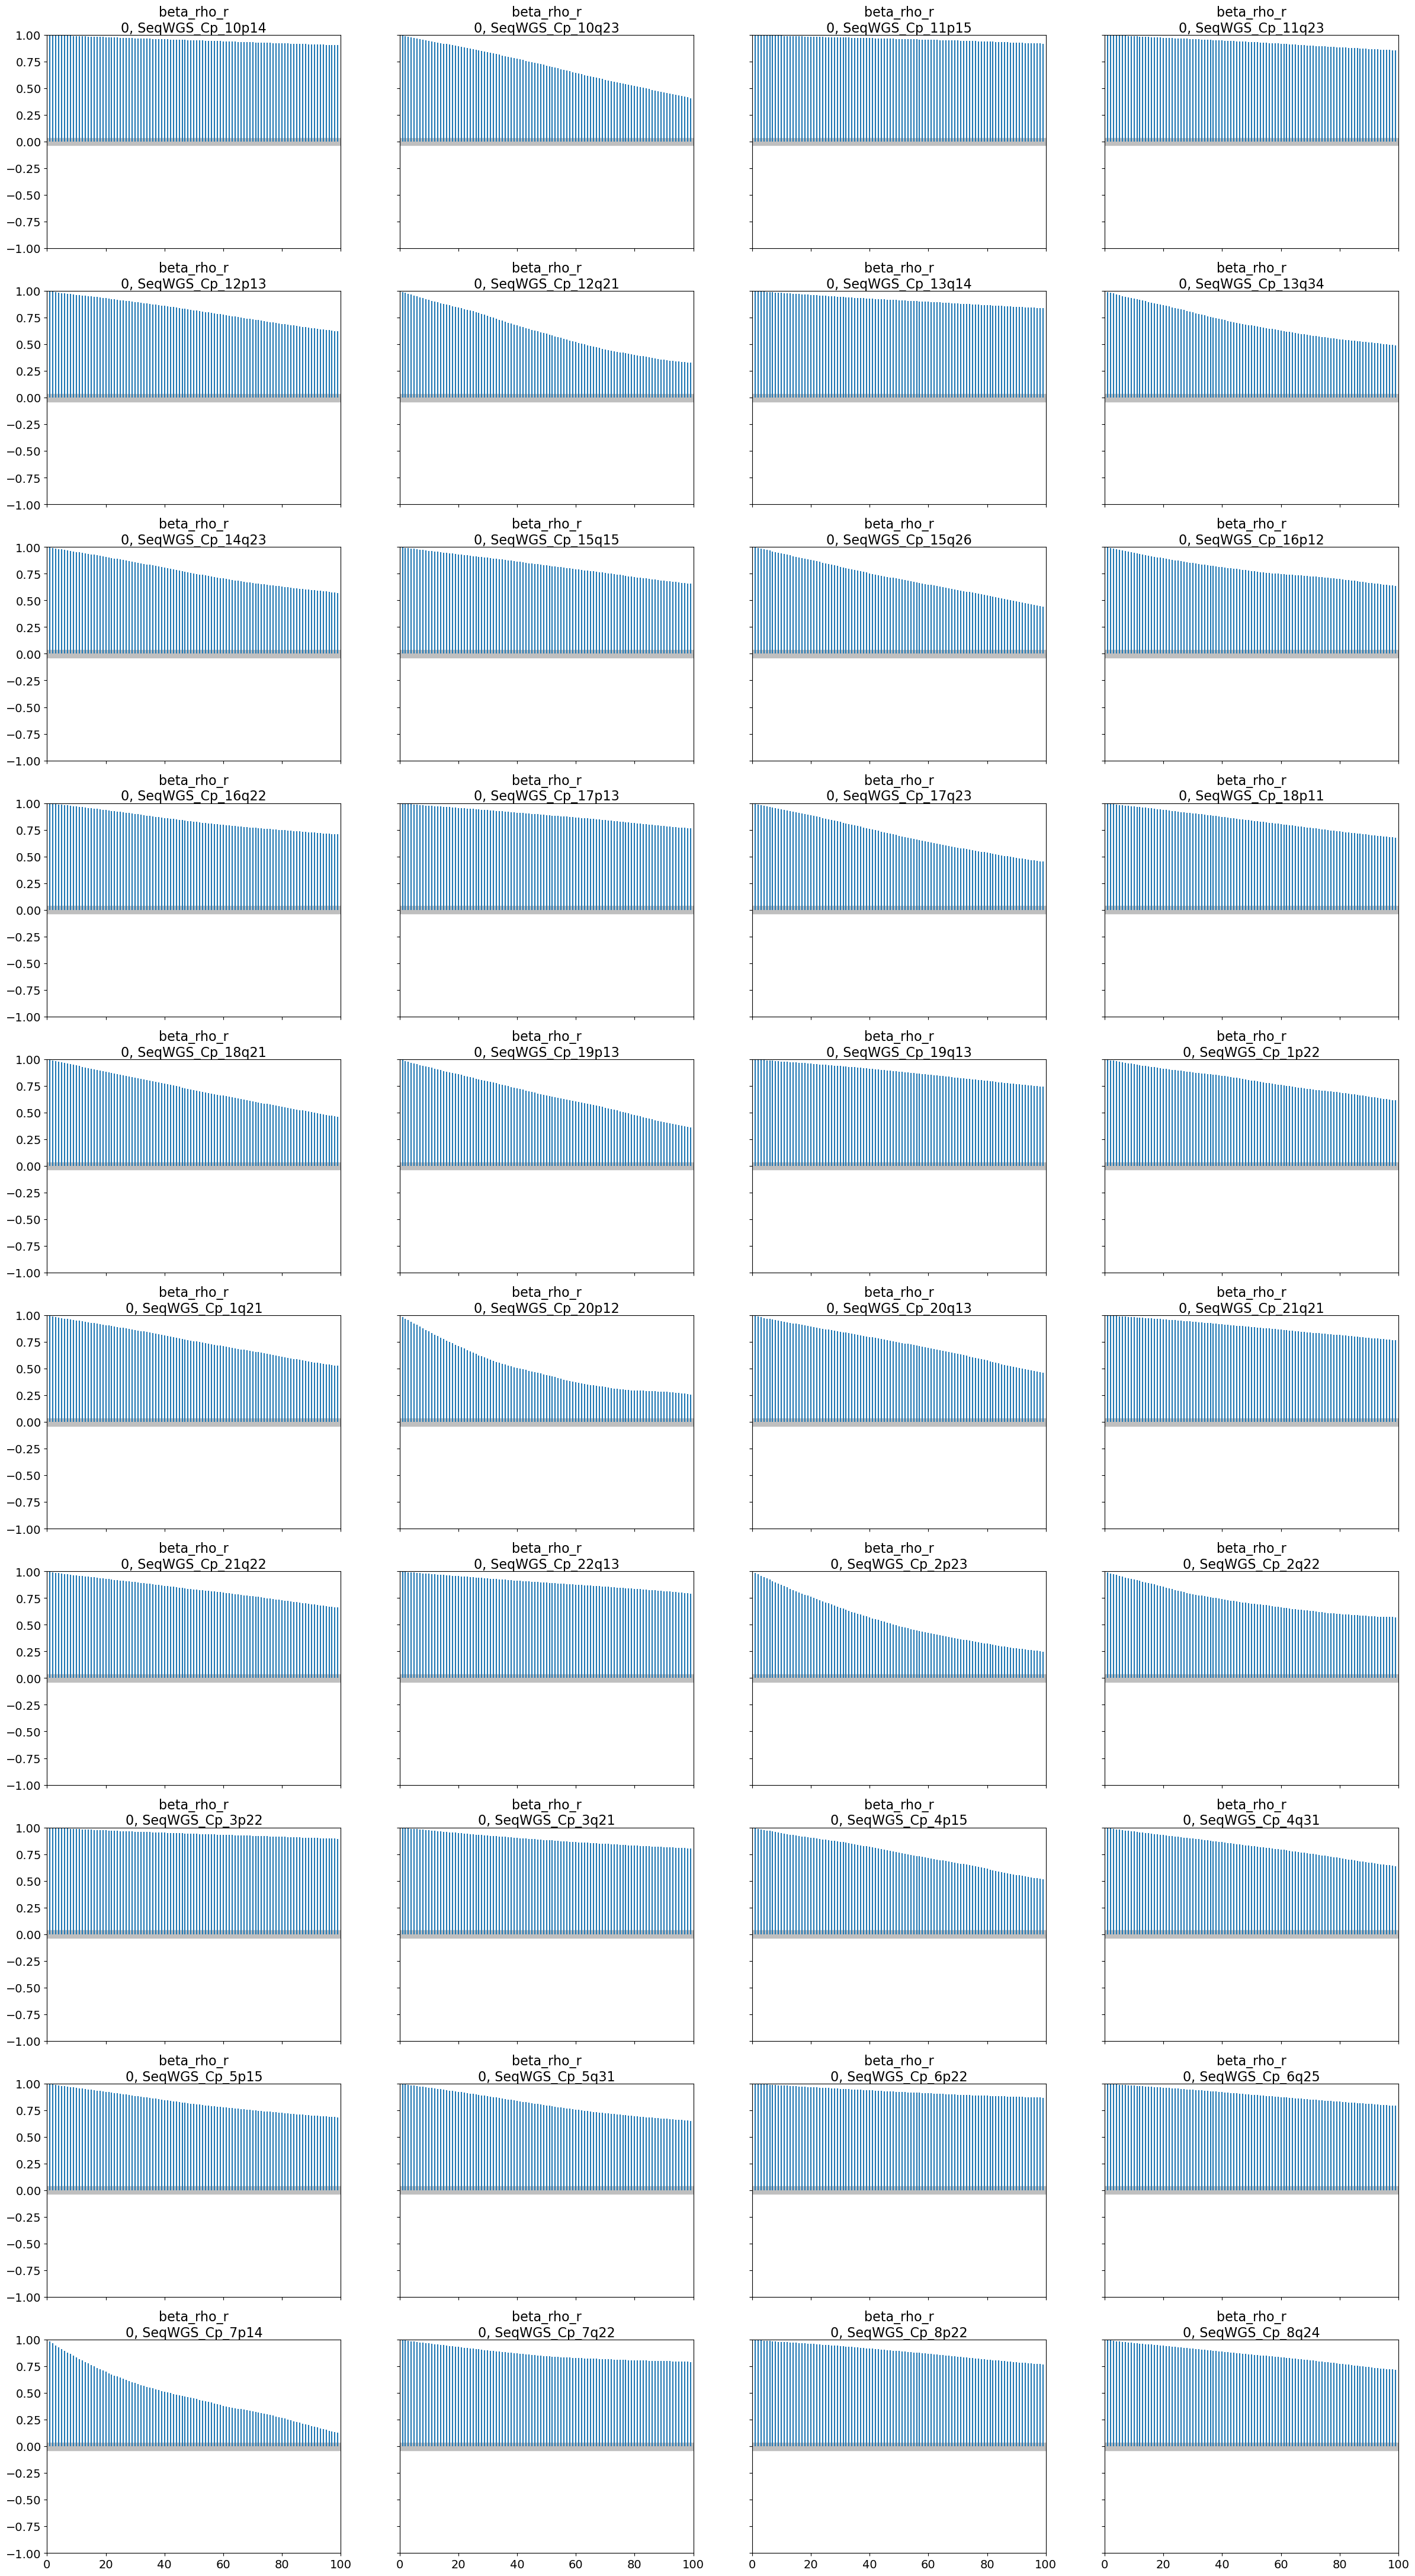

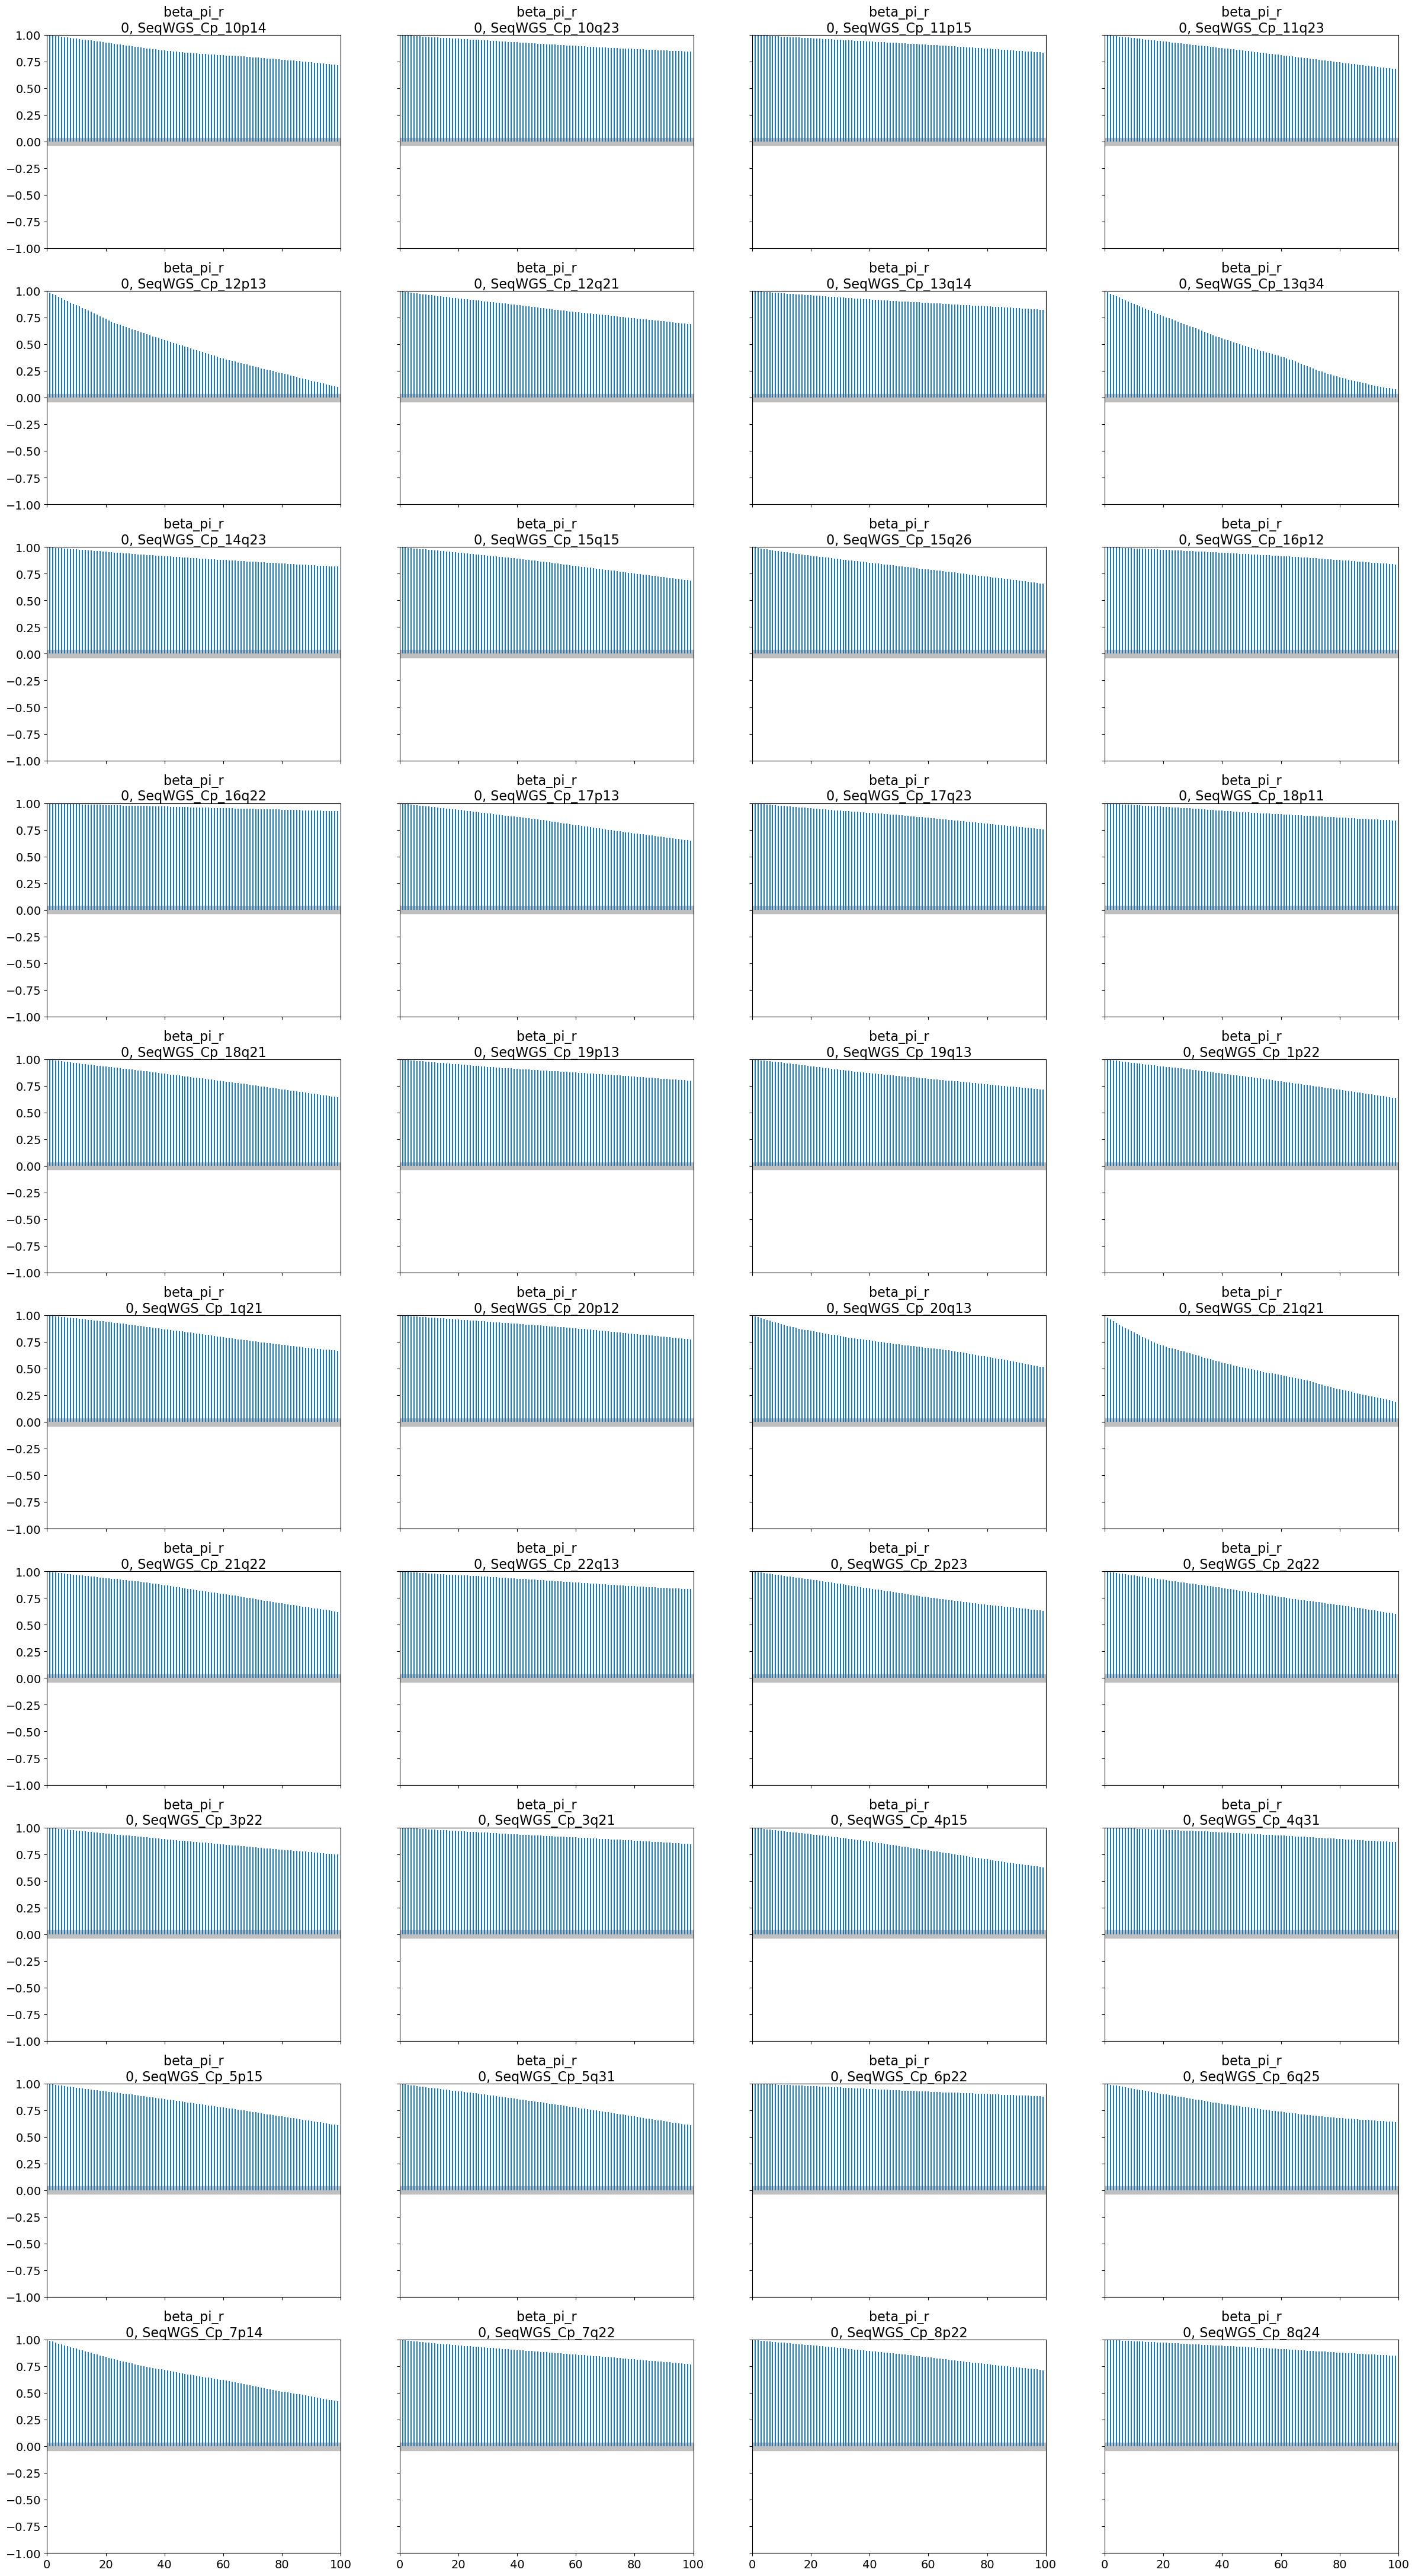

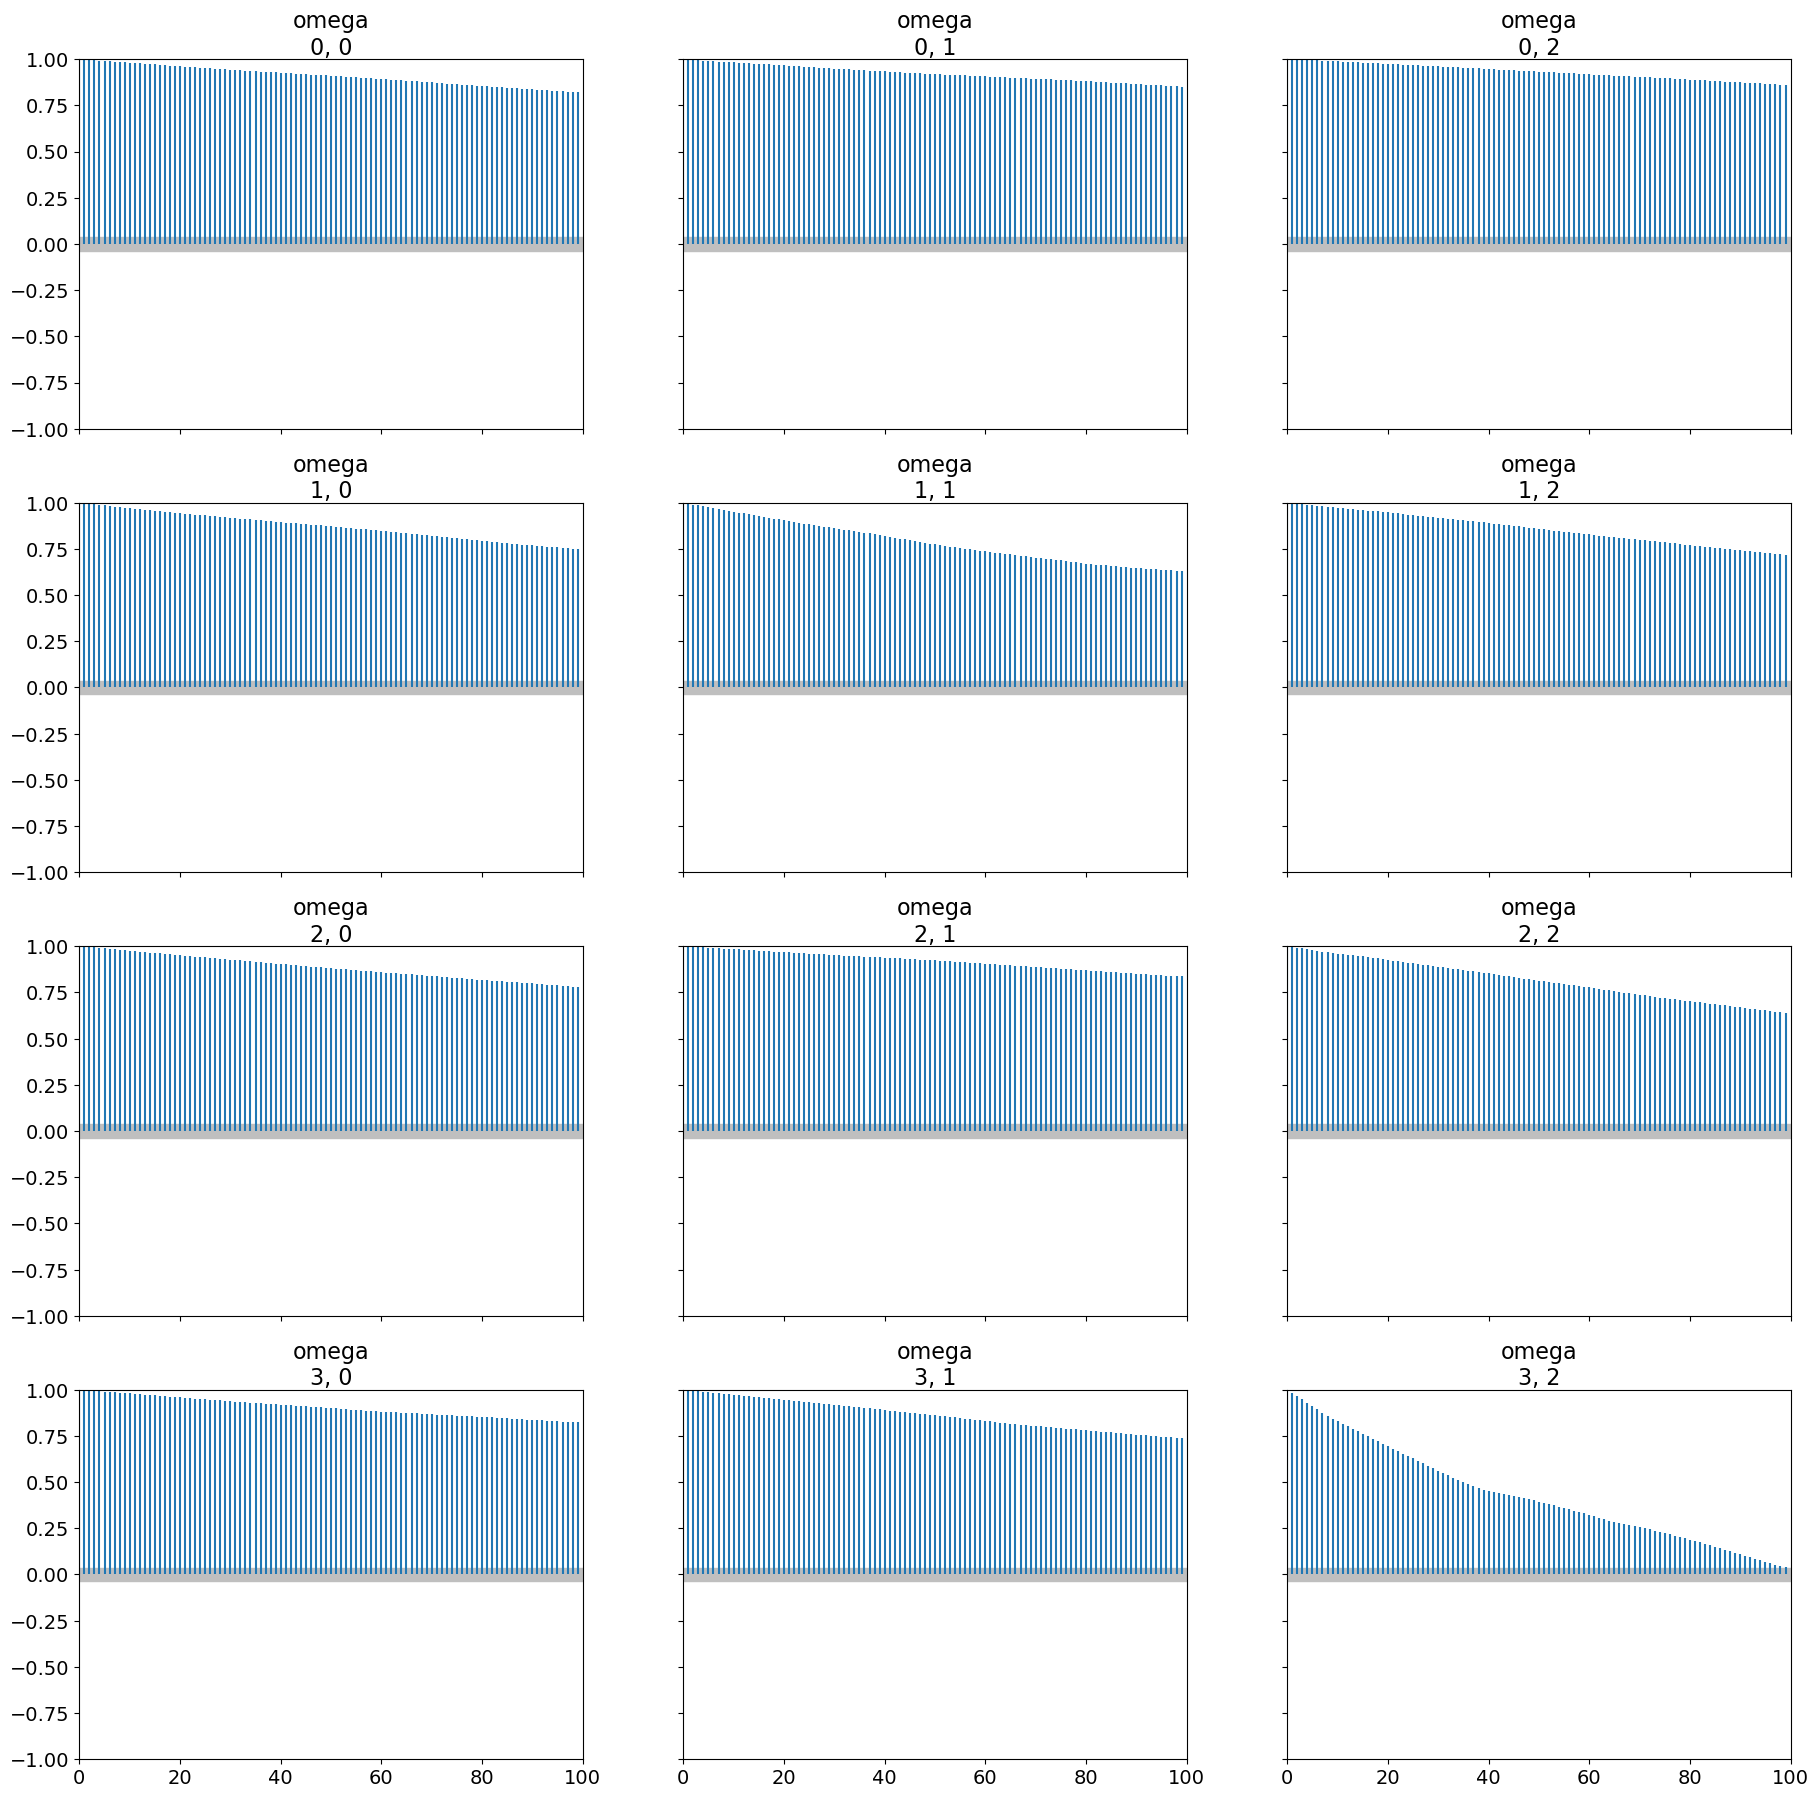

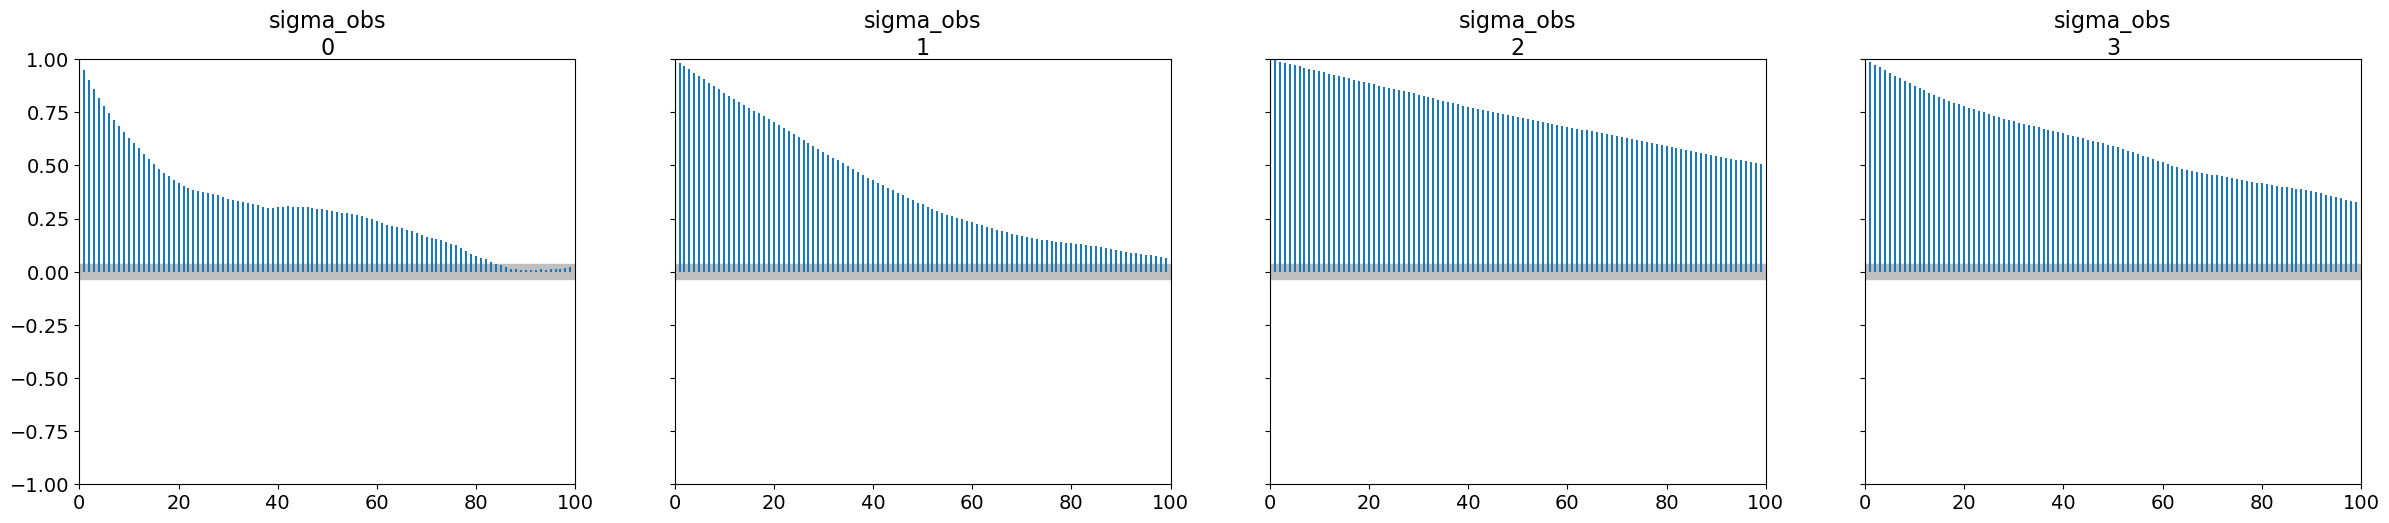

In [6]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
az.plot_autocorr(idata, var_names=["alpha"]);
az.plot_autocorr(idata, var_names=["beta_rho_s"]);
az.plot_autocorr(idata, var_names=["beta_rho_r"]);
az.plot_autocorr(idata, var_names=["beta_pi_r"]);
az.plot_autocorr(idata, var_names=["omega"]);
az.plot_autocorr(idata, var_names=["sigma_obs"]);

In [7]:
# Posterior means 
print("List of covariates:", idata.posterior.coords['predictors'])
print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
print('\nPosterior average of beta_rho_s:\n', np.mean(idata.posterior['beta_rho_s'], axis=(0,1)))
print('\nPosterior average of beta_rho_r:\n', np.mean(idata.posterior['beta_rho_r'], axis=(0,1)))
print('\nPosterior average of beta_pi_r:\n', np.mean(idata.posterior['beta_pi_r'], axis=(0,1)))
print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

List of covariates: <xarray.DataArray 'predictors' (predictors: 164)>
array(['SeqWGS_Cp_10p14', 'SeqWGS_Cp_10q23', 'SeqWGS_Cp_11p15',
       'SeqWGS_Cp_11q23', 'SeqWGS_Cp_12p13', 'SeqWGS_Cp_12q21',
       'SeqWGS_Cp_13q14', 'SeqWGS_Cp_13q34', 'SeqWGS_Cp_14q23',
       'SeqWGS_Cp_15q15', 'SeqWGS_Cp_15q26', 'SeqWGS_Cp_16p12',
       'SeqWGS_Cp_16q22', 'SeqWGS_Cp_17p13', 'SeqWGS_Cp_17q23',
       'SeqWGS_Cp_18p11', 'SeqWGS_Cp_18q21', 'SeqWGS_Cp_19p13',
       'SeqWGS_Cp_19q13', 'SeqWGS_Cp_1p22', 'SeqWGS_Cp_1q21',
       'SeqWGS_Cp_20p12', 'SeqWGS_Cp_20q13', 'SeqWGS_Cp_21q21',
       'SeqWGS_Cp_21q22', 'SeqWGS_Cp_22q13', 'SeqWGS_Cp_2p23',
       'SeqWGS_Cp_2q22', 'SeqWGS_Cp_3p22', 'SeqWGS_Cp_3q21', 'SeqWGS_Cp_4p15',
       'SeqWGS_Cp_4q31', 'SeqWGS_Cp_5p15', 'SeqWGS_Cp_5q31', 'SeqWGS_Cp_6p22',
       'SeqWGS_Cp_6q25', 'SeqWGS_Cp_7p14', 'SeqWGS_Cp_7q22', 'SeqWGS_Cp_8p22',
       'SeqWGS_Cp_8q24', 'SeqWGS_Cp_9p13', 'SeqWGS_Cp_9q33', 'SeqWGS_Cp_BIRCs',
       'SeqWGS_Cp_CDKN2C', 'SeqWGS_Cp_CY

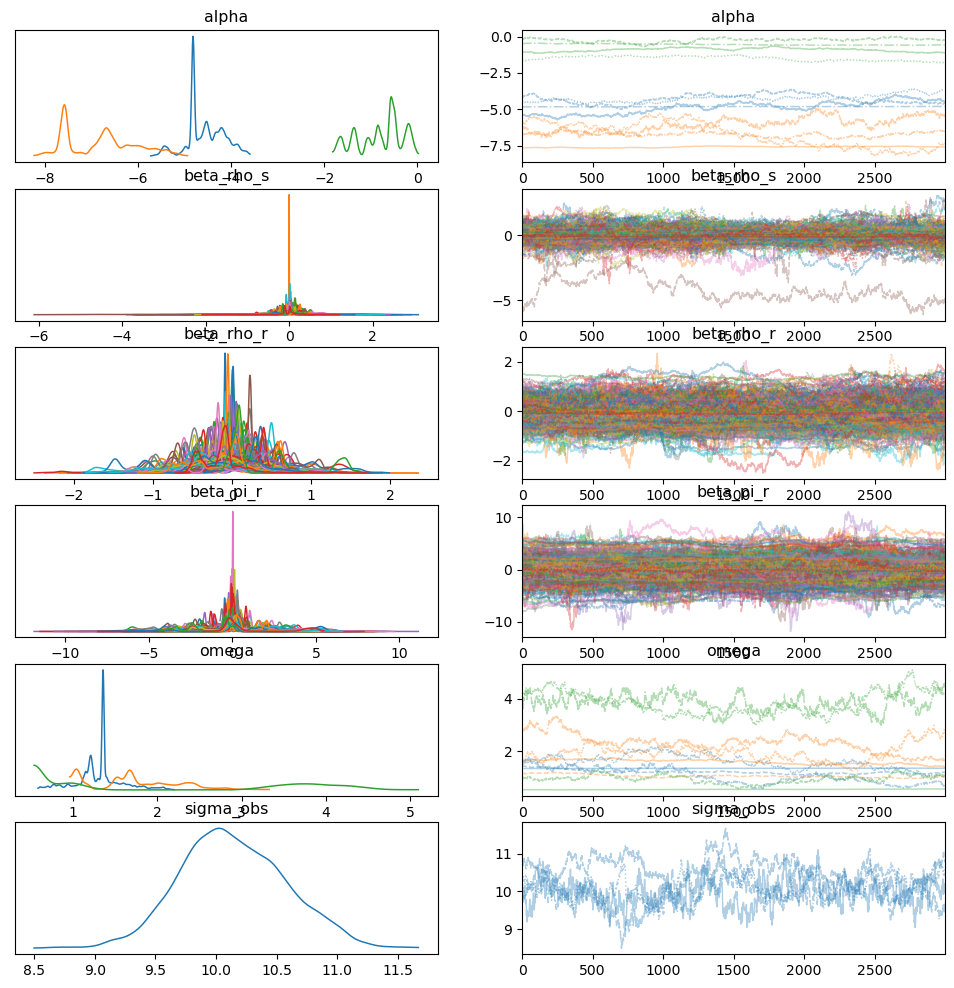

In [8]:
az.plot_trace(idata, var_names=('alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

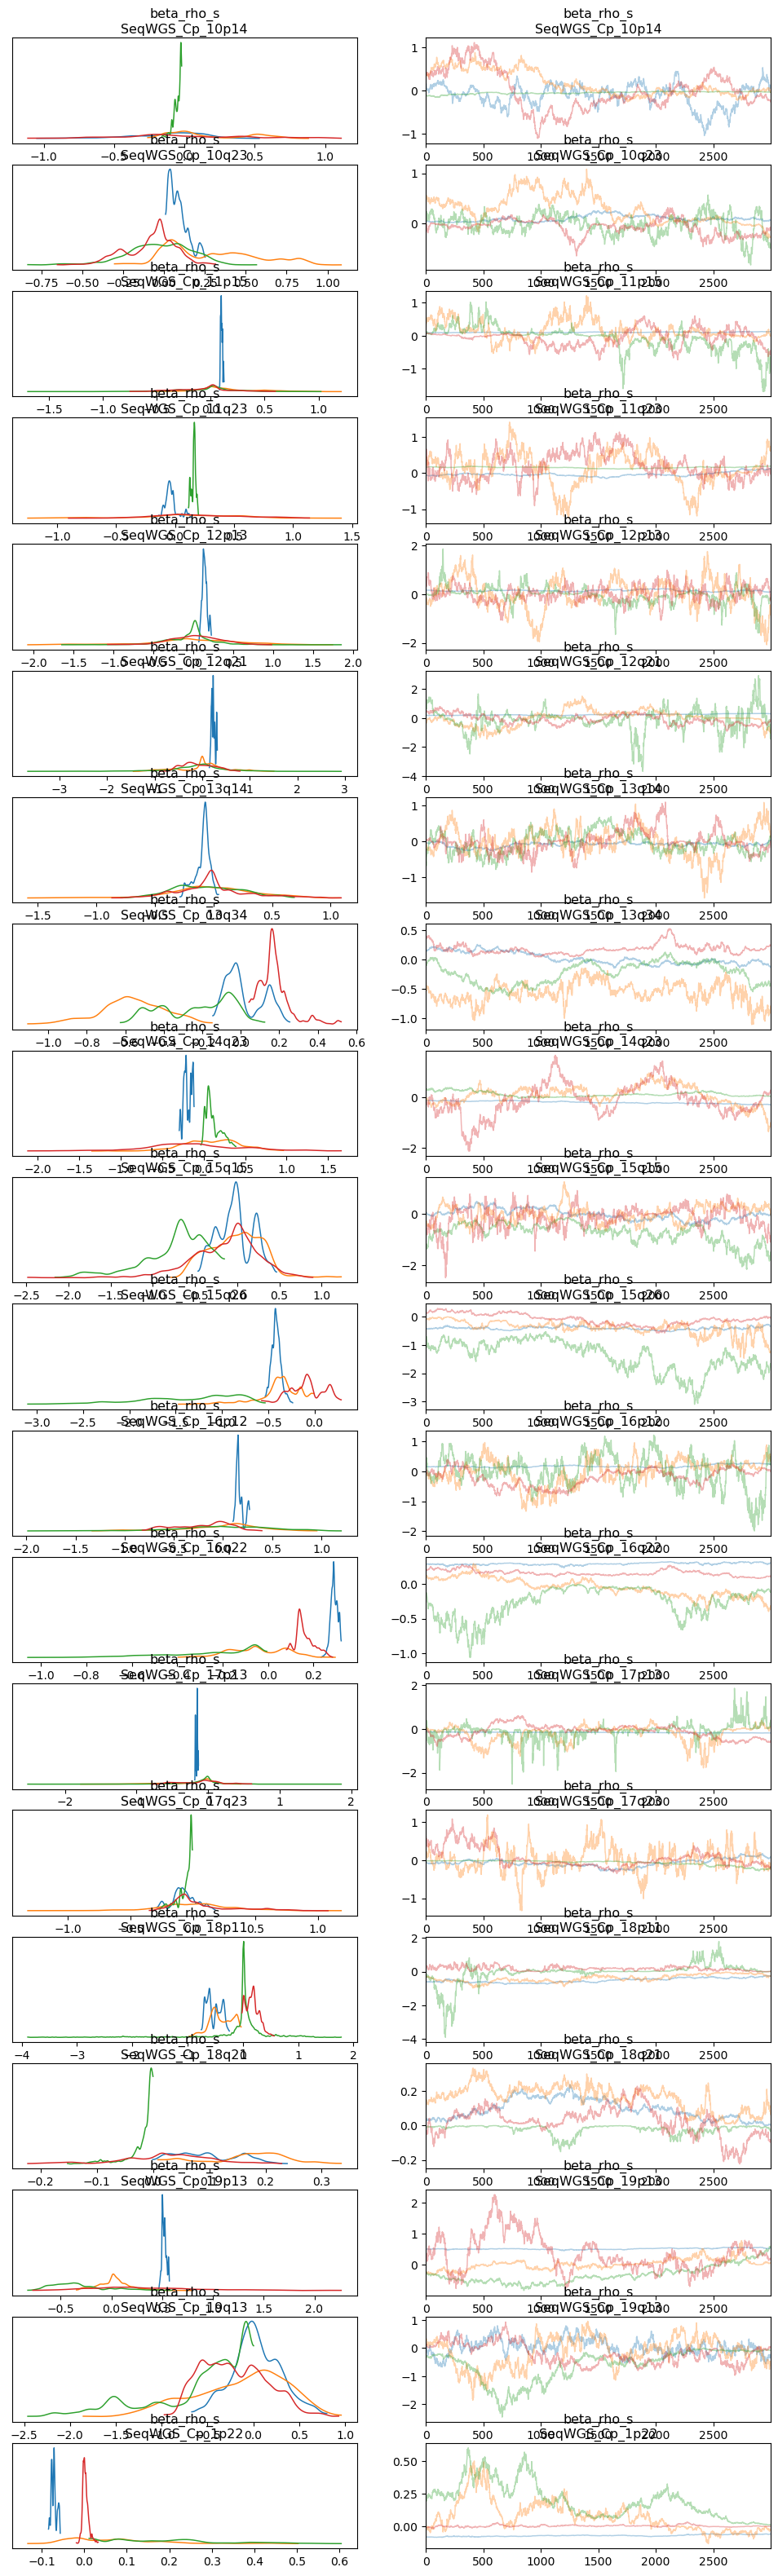

In [9]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_s'), lines=[('beta_rho_s', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_s.png")
# There seems to be an effect where Age contributes towards higher growth rate for sensitive cells

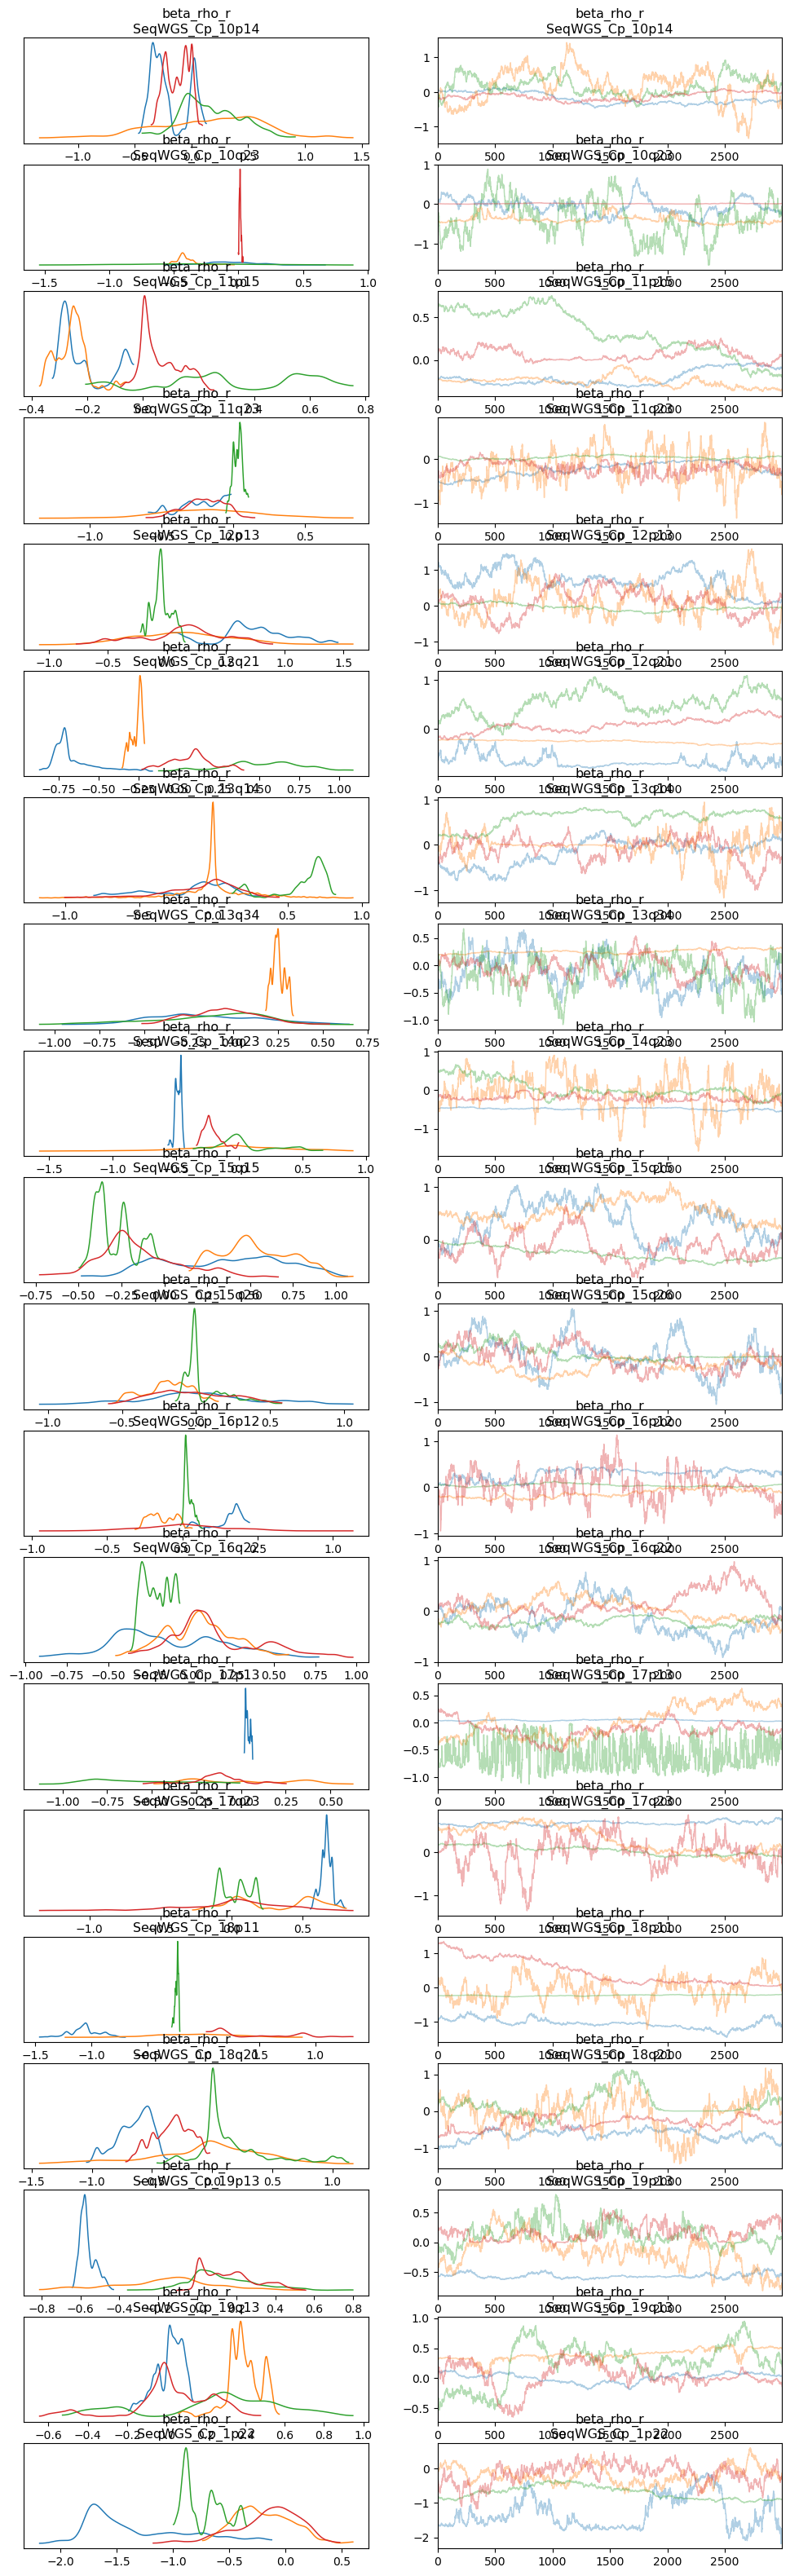

In [10]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_r'), lines=[('beta_rho_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_r.png")

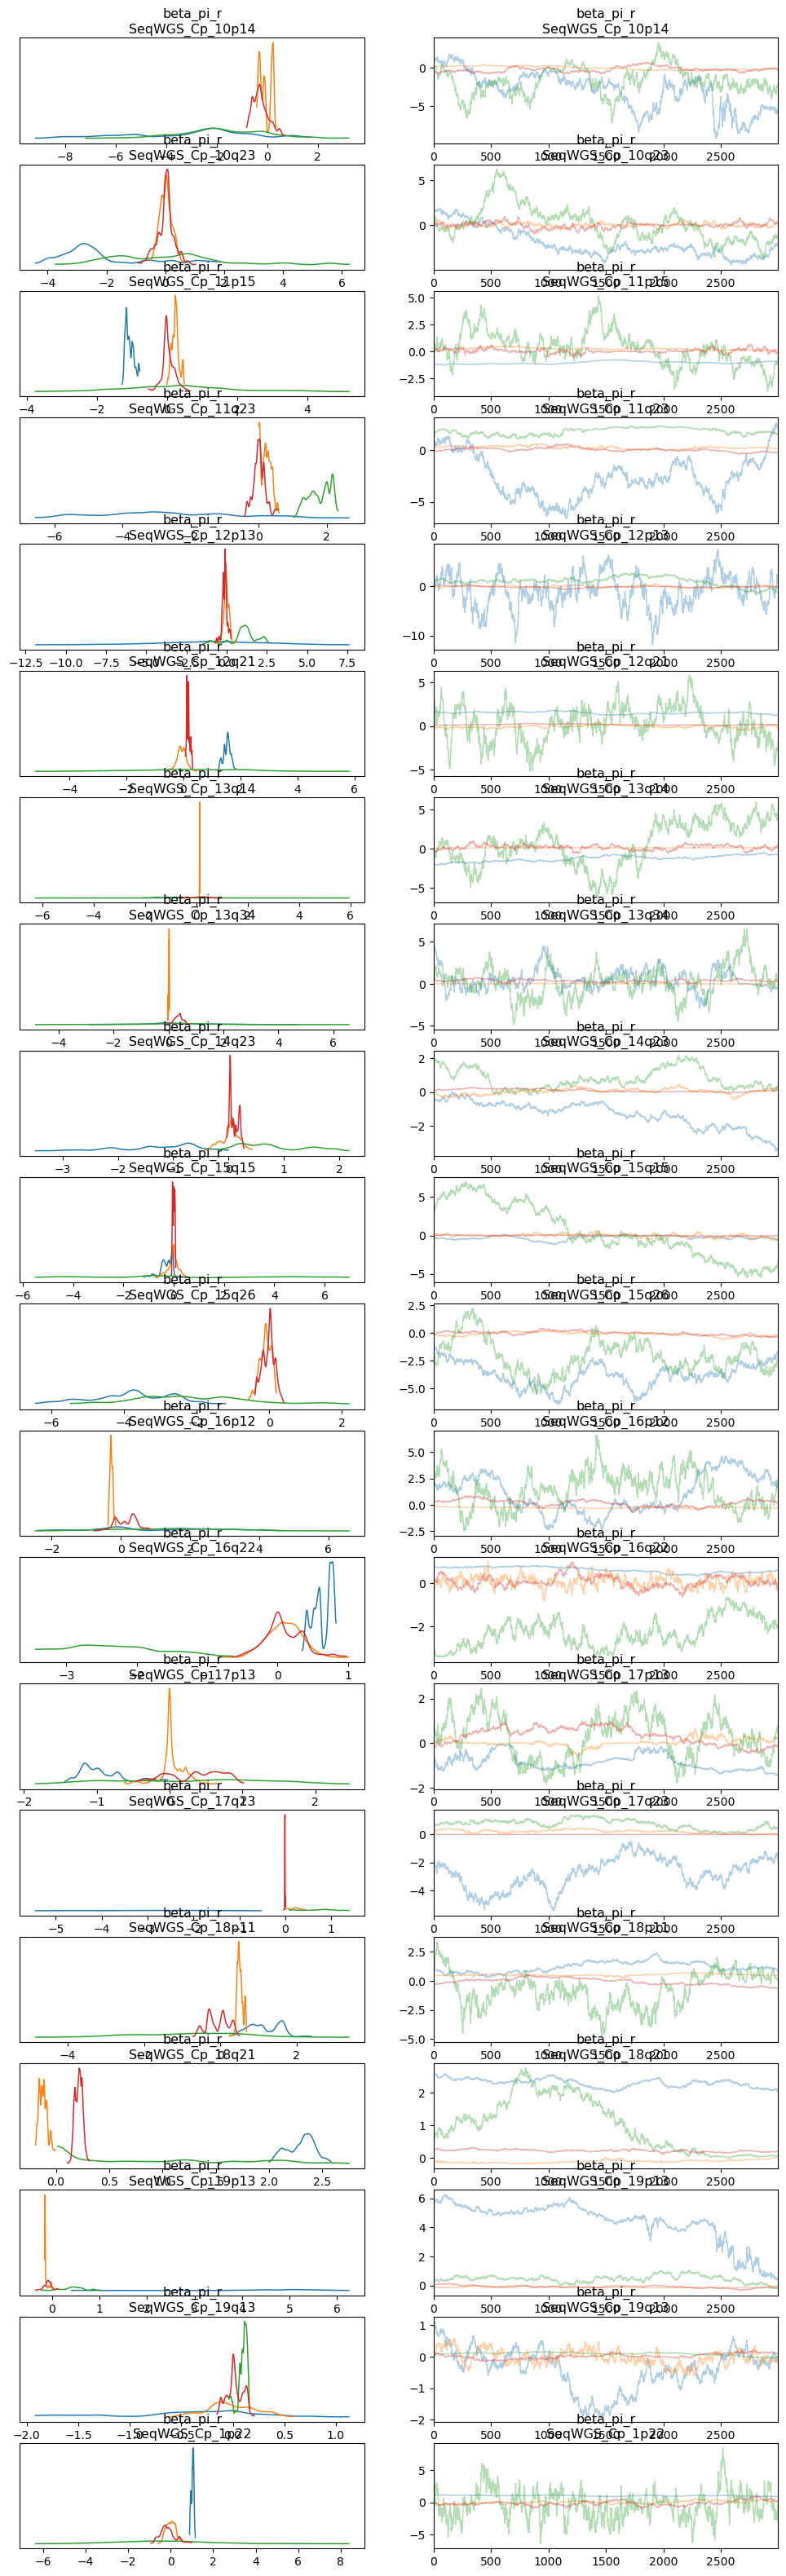

In [11]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_pi_r'), lines=[('beta_pi_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.

In [12]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
az.plot_energy(idata)
plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["beta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["beta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["beta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_pi_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [ ]:
# Get posterior median parameter estimates for visualization
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print("Median sigma_obs:", median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print("First patient's median parameters:", estimated_parameters_dict[0].to_array_with_sigma())

# Plot patient estimates
for training_instance_id, patient in patient_dictionary.items():
    estimated_parameters = estimated_parameters_dict[training_instance_id]
    patient.treatment_history = [Treatment(patient.measurement_times[0], patient.measurement_times[-1], 0)]
    #patient.print()
    savename = "./plots/Bayesian_estimates/training_id_"+str(training_instance_id)+"_treat_id"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_median_parameters__Y_0="+str(estimated_parameters.Y_0)+", pi_r="+str(estimated_parameters.pi_r)+", g_r="+str(estimated_parameters.g_r)+", g_s="+str(estimated_parameters.g_s)+", k_1="+str(estimated_parameters.k_1)+", sigma="+str(estimated_parameters.sigma)+".png"
    plot_treatment_region_with_estimate(estimated_parameters, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Posterior median for "+str(training_instance_id), savename=savename)

Median sigma_obs: 23.839563862391902
First patient's median parameters: [ 8.36411676e+01  6.63624670e-03  5.17922178e-04 -6.78787456e-02
  0.00000000e+00  2.38395639e+01]
